**Relevant resources:**

* [Unsloth Github](https://github.com/unslothai/unsloth)
* [Llama 3.1 Base 8b Model](https://huggingface.co/unsloth/Meta-Llama-3.1-8B-bnb-4bit)
* [Llama 3.1 Instruct 8b Model](https://huggingface.co/unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit)
* [Llama-3.1 8b + Unsloth 2x faster finetuning](https://colab.research.google.com/drive/1Ys44kVvmeZtnICzWz0xgpRnrIOjZAuxp?usp=sharing)
* [Llama-3 8b Instruct Unsloth 2x faster finetuning](https://colab.research.google.com/drive/1XamvWYinY6FOSX9GLvnqSjjsNflxdhNc?usp=sharing)

**Load model from Unsloth**

In [1]:
from unsloth import FastLanguageModel
import torch
torch.cuda.empty_cache()
max_seq_length = 1024 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct",
    attn_implementation="flash_attention_2",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.0.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.988 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


**Add LoRA adapters**

In [2]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


### Load Data

* [Loading dataset from different formats](https://huggingface.co/docs/datasets/en/loading)
* [Loading dataset from SQLite3 database](https://huggingface.co/docs/datasets/main/en/tabular_load#sqlite)
* [Llama 3.1 Instruct Prompt Format](https://llama.meta.com/docs/model-cards-and-prompt-formats/llama3_1/#llama-3.1-instruct)

In [ ]:
from datasets import Dataset

def format_prompts(examples):
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []
    for input_txt, output_txt in zip(inputs, outputs):
        text = [
            {"role": "system", "content": "You are a helpful assistant"},
            {"role": "user", "content": input_txt},
            {"role": "assistant", "content": output_txt}
        ]
        texts.append(tokenizer.apply_chat_template(text, tokenize=False))
    return {"text": texts,}

db_file = "./reddit.db"
uri = f"sqlite:///{db_file}"
dataset = Dataset.from_sql("SELECT input, output FROM train", con=uri)
dataset = dataset.map(format_prompts, batched = True,)

In [27]:
# print(dataset[5]["text"])

### Train model

* [Supervised Fine-tuning Trainer](https://huggingface.co/docs/trl/sft_trainer)

In [4]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        # max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

**Show current memory stats**

In [5]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4090. Max memory = 23.988 GB.
5.984 GB of memory reserved.


In [6]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 15,063 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 1,883
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,3.431200
2,3.616800
3,3.322400
4,3.292200
5,3.212300
6,3.049600
7,3.051600
8,2.776000
9,2.807900
10,2.680200


**Show final memory and time stats**

In [21]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

4249.2419 seconds used for training.
70.82 minutes used for training.
Peak reserved memory = 7.82 GB.
Peak reserved memory for training = 1.836 GB.
Peak reserved memory % of max memory = 32.6 %.
Peak reserved memory for training % of max memory = 7.654 %.


**Show training loss over time**

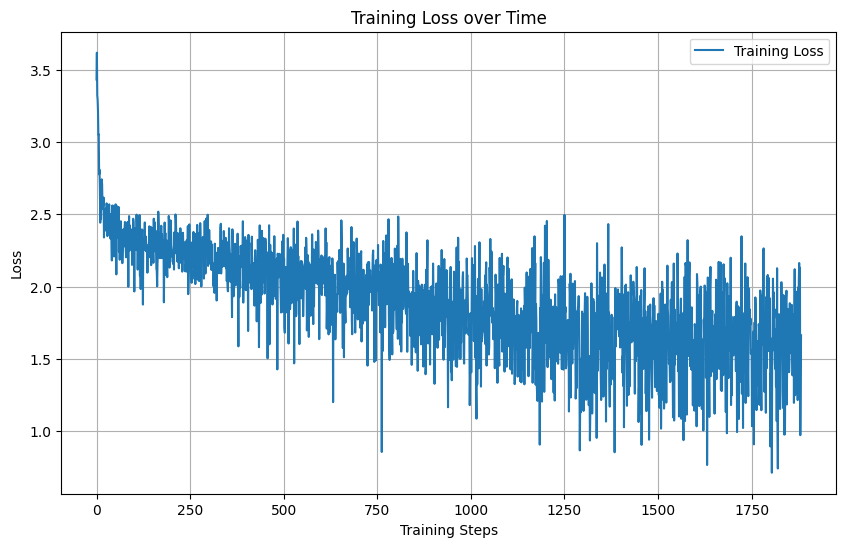

In [18]:
import matplotlib.pyplot as plt

# Extract the loss values
loss_values = trainer.state.log_history

# Extracting only the loss from each log entry
training_loss = [entry['loss'] for entry in loss_values if 'loss' in entry]

# Plotting the loss over time
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.legend()
plt.grid(True)
plt.show()

**Save finetuned model**

In [8]:
model.save_pretrained("lora_model")
print("model saved")

model saved


### Inference

In [ ]:
prompt = ""
msgs = [{"role": "user", "content": prompt},]
FastLanguageModel.for_inference(model)
inputs = tokenizer.apply_chat_template(
    msgs,
    tokenize = True,
    add_generation_prompt = True,
    return_tensors = "pt"
).to("cuda")

outputs = model.generate(input_ids = inputs, min_new_tokens = 32, max_new_tokens = 2048, use_cache=True)
print(tokenizer.batch_decode(outputs)[0])